# Transaction Settlement on Quantum Computers

Transaction settlement is an important problem in finance. When trades are executed, they aren't actually settled until later, typically called "T+2". Many billions of dollars are traded in the U.S. everyday. While transaction settlement may seem like a rare occurrence, [5-10% of equity trades failed to settle between 2018 and 2020](https://www.swift.com/news-events/news/settlement-fails-getting-root-problem). That translates to billions of losses in penalties and inefficiencies. In this notebook, we'll walk through a formulation of the transaction settlement problem that maximizes the number of settled transactions.

## Problem formulation

## A Simple Example

First, let's walk through a simple example involving three parties and three transactions. This simple example is written about in the IBM/Barclays paper cited at the bottom of this notebook. For this problem, each party has no credit limit for its currency or security traded.

In [15]:
import qubovert as qv
import sympy
import networkx as nx
import matplotlib.pyplot as plt
from transaction_settlement_helper import * # helper functions (not publically available)

In [16]:
# information about each parties balances
parties =  {
    1 : {'balance' : {'currency' : 2, 'securities' : 0}, 
         'credit_limit' : {'currency' : 0, 'securities' : 0},
        },
    2 : {'balance' : {'currency' : 0, 'securities' : 3},  
         'credit_limit' : {'currency' : 0, 'securities' : 0},
        },
    3 : {'balance' : {'currency' : 0, 'securities' : 0}, 
         'credit_limit' : {'currency' : 0, 'securities' : 0},
        },
}

# information about the transactions to settle
transactions = {
    1 : {'delivery' : {'type' : 's', 'value' : 2}, 
         'payment' : {'type' : 'c', 'value'  : 1},
         'securities_from' : 2,
         'securities_to' : 1,
         'weight' : 1,
        },
    2 : {'delivery' : {'type' : 's', 'value' : 2}, 
         'payment' : {'type' : 'c', 'value'  : 1},
         'securities_from' : 2,
         'securities_to' : 3,
         'weight' : 1,
        },
    3 : {'delivery' : {'type' : 's', 'value' : 2}, 
         'payment' : {'type' : 'c', 'value'  : 1},
         'securities_from' : 3,
         'securities_to' : 1,
         'weight' : 1,
        },
}

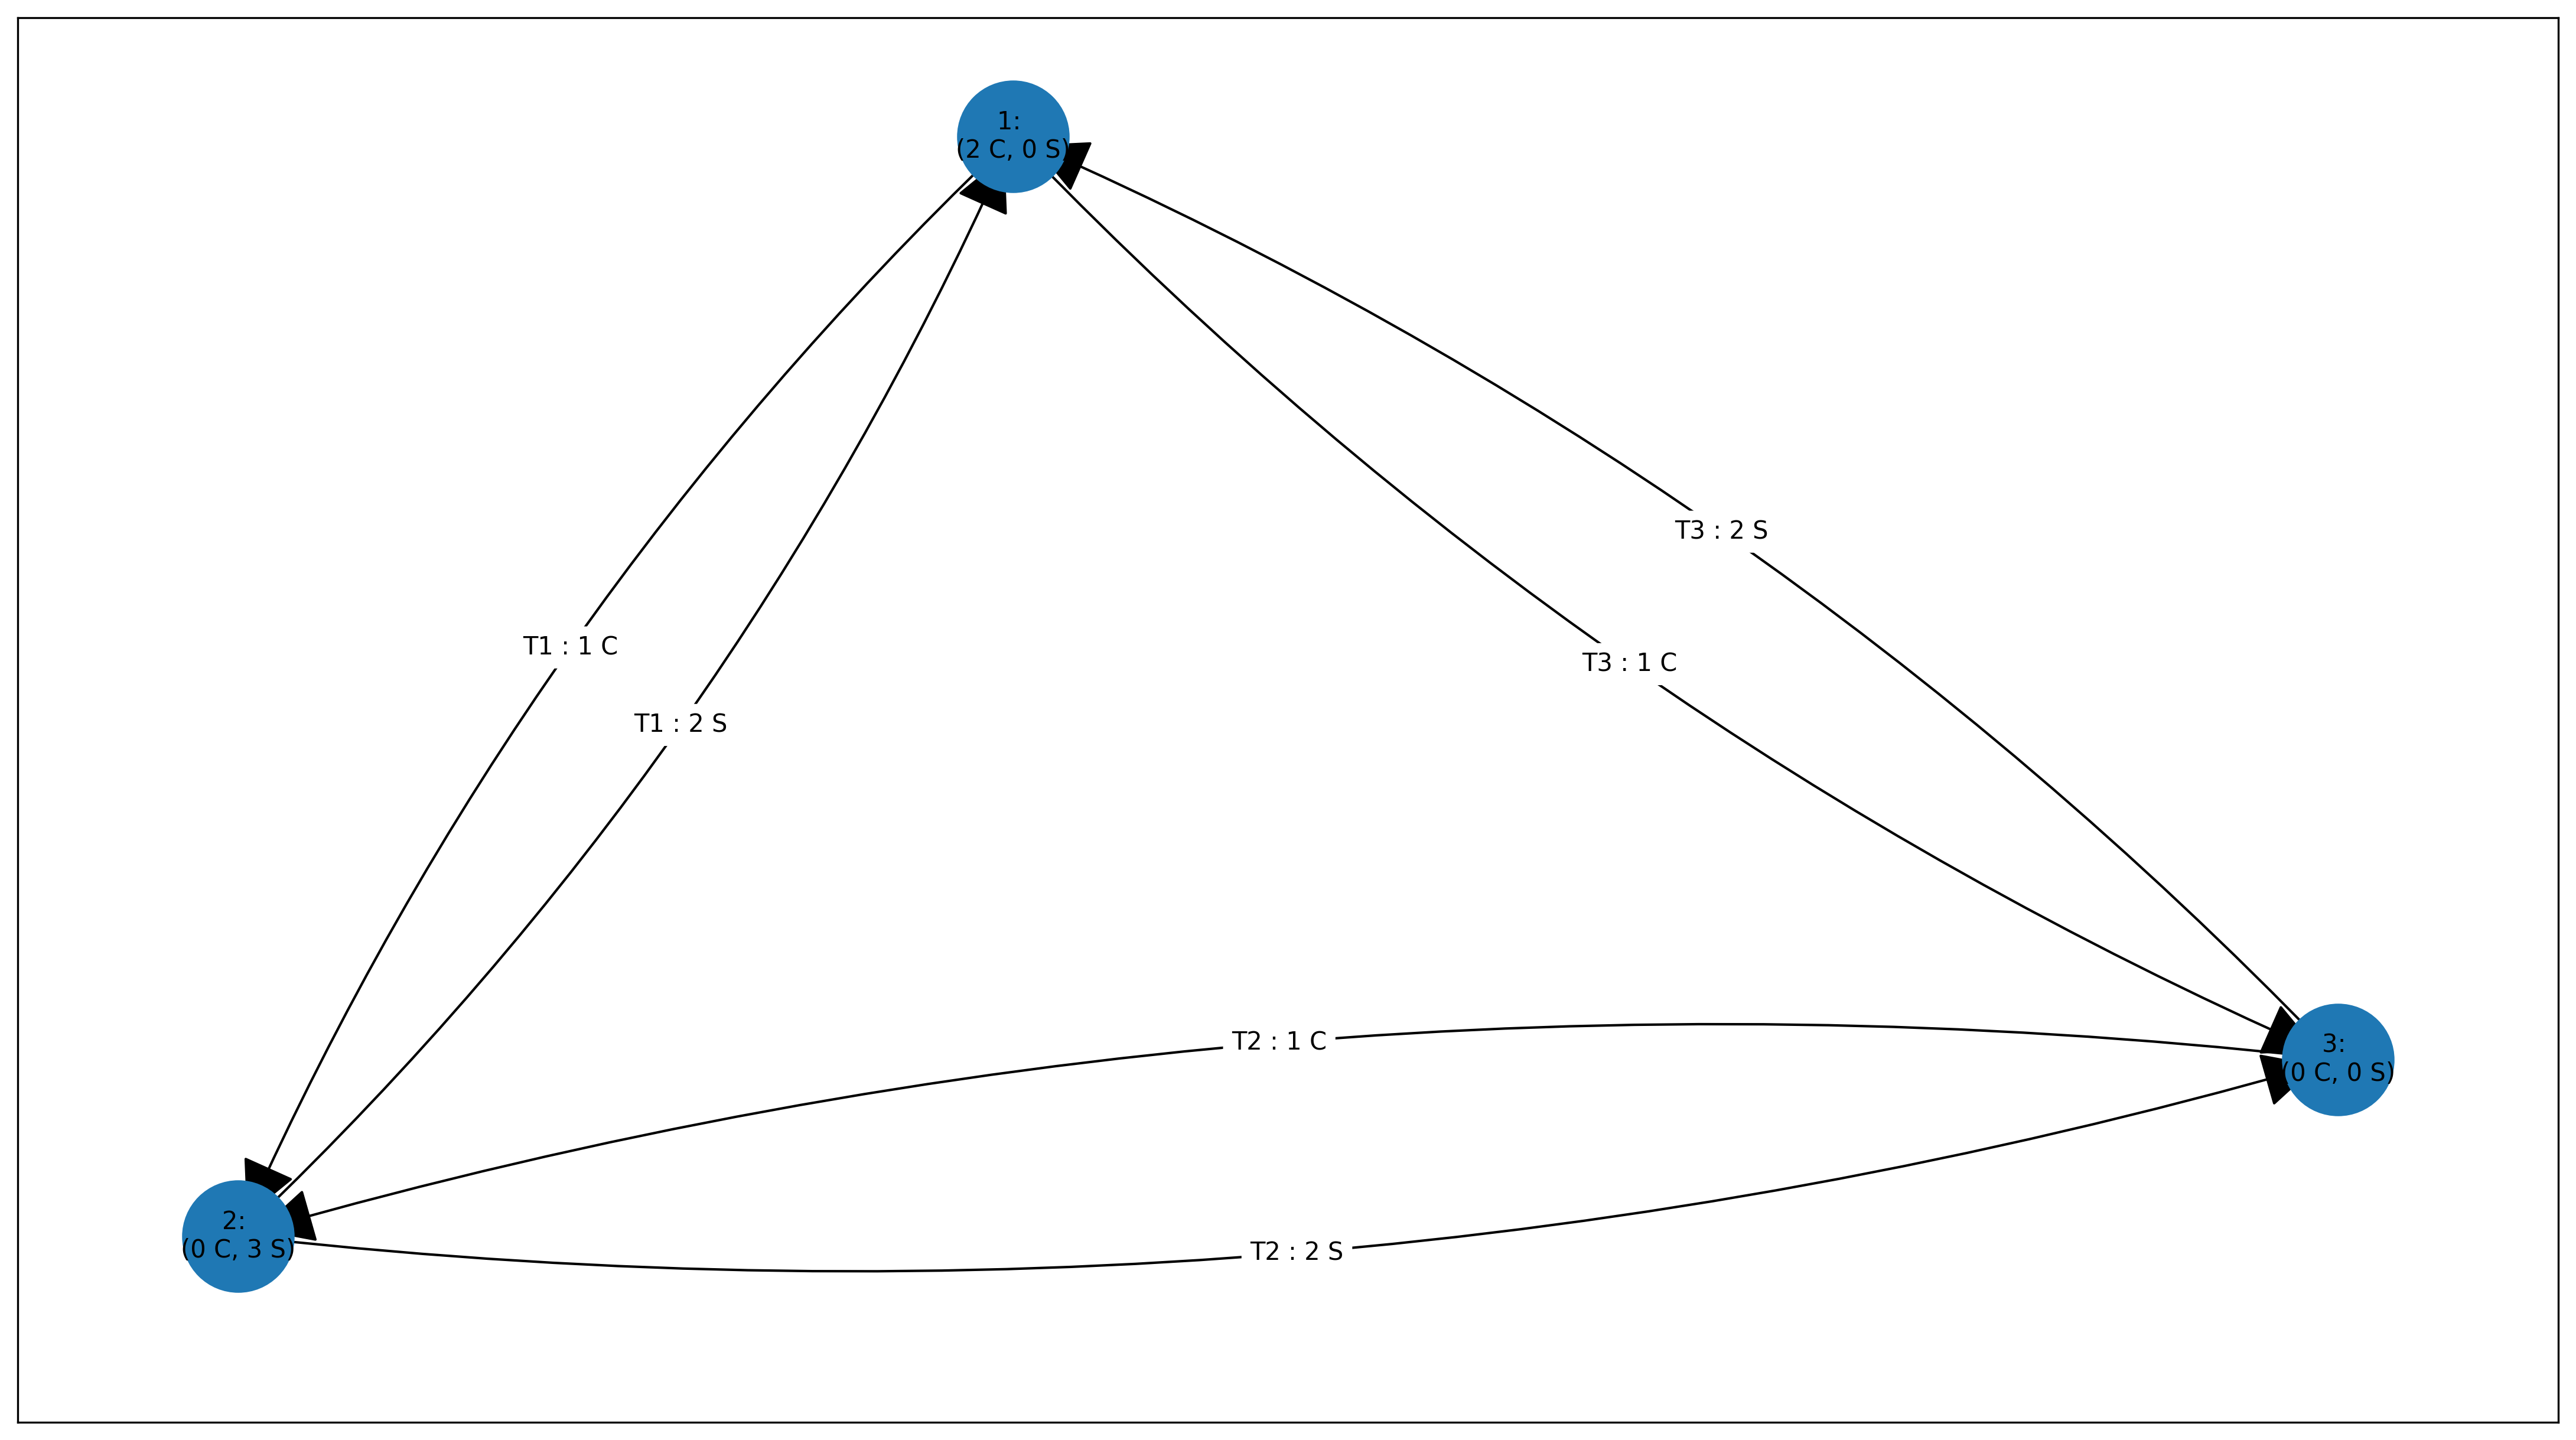

In [17]:
draw_transaction_graph(parties, transactions)

Nodes are labeled with each party and its currency balance (C) and securities balances (S). Each transaction is labeled (T1, T2, T3 with corresponding currency and securities traded).

Naively, if we looked only at each transaction individually, we see that T2 couldn't be settled since party 3 has 0 C and is trading 1 C to party 2. T3 couldn't be settled since party 3 has 0 S and is trading 2 S to party 1. So, transaction 1 is only able to be settled.

However, if we took a closer look, we could settle transactions 2 and 3. Party 3 would get the 1 C it needs for T2 via T3 and the 2 S it needs for T3 from T2.

The naive method is sub-optimal clearly. Two transactions that are unable to be settled on their own could combine to be settled. The more sophisticsated approach has its issues too though. We could check all combinations of transactions to settle and check if the combination is valid. In general, if we have $n$ transactions, we could settle $n$ choose $1$ $+$ $n$ choose $2$ $+ ... +$ $n$ choose $n$. For this example, that only works out to $3 + 3 + 1 = 7$ combinations to check for validity. 

Quickly though, that number of combinations explodes. For example, with 50 transactions, $50$ choose $25$ is over 120 trillion, far too many combinations for a classical computer to check.

## The Quantum Solution

This type of problem is NP-Hard and can be formulated as a Quadratic Unconstrained Binary Optimization (QUBO) problem for $N$ transactions:

max $\sum_{i=0}^N w_ix_i$ 

s.t. $b_k + \sum x_iv_{ik}$ $\ge$ $ l_k$ $\forall k$

where 

- $w_i$ is the transaction weight
- $x_i$ is binary variable for whether or not we settle a transaction
- $b_k$ is the balance of party $k$ (for both currency and the security being traded)
- $v_{ik}$ is the currency value of the $i$th transaction of party $k$
- $l_k$ is the credit limit for account $k$

Since we seek to maximize the number of transactions settled, we make each $w_i = 1$, but we could adjust that to prioritize certain types of transactions.

In [18]:
x, obj, lam = create_variables_and_objective_function(parties, transactions)

In [19]:
M = 10
obj = obj.subs({lam : M})
print(f'Number of binary variables: {len(obj.variables)}')

Number of binary variables: 7


In [20]:
from qubovert.sim import anneal_qubo
from scipy.stats import norm
from pprint import pprint
%time res = anneal_qubo(obj, num_anneals=100)
solution = res.best.state

Wall time: 56 ms


In [21]:
transactions_to_settle = []
for sol in solution:
    if sol.split("_")[0] == 'x' and solution[sol] == 1:
        transactions_to_settle.append(sol.split("_")[1])
print("Settle these transactions: ")
transactions_to_settle

Settle these transactions: 


['2', '3']

The quantum solution finds the more optimal method of settling the transactions.

## A Larger Example

Now let's create a larger, random instance of the problem and solve it.

In [22]:
import random

In [23]:
num_parties = 10
num_transactions = 30
parties = {}
transactions = {}
for party in range(1,num_parties+1):
    parties[party] = {
        'balance' : {'currency' : random.randint(5,10), 'securities' : random.randint(5,10)}, 
         'credit_limit' : {'currency' : 0, 'securities' : 0},
    }

for transaction in range(1, num_transactions+1):
    from_party = random.randint(1,num_parties)
    to_party = from_party
    while to_party == from_party:
        to_party = random.randint(1, num_parties)
    
    transactions[transaction] = {
        'delivery' : {'type' : 's', 'value' : random.randint(1,5)}, 
         'payment' : {'type' : 'c', 'value'  : random.randint(1,5)},
         'securities_from' : from_party,
         'securities_to' : to_party,
         'weight' : 1,
    }

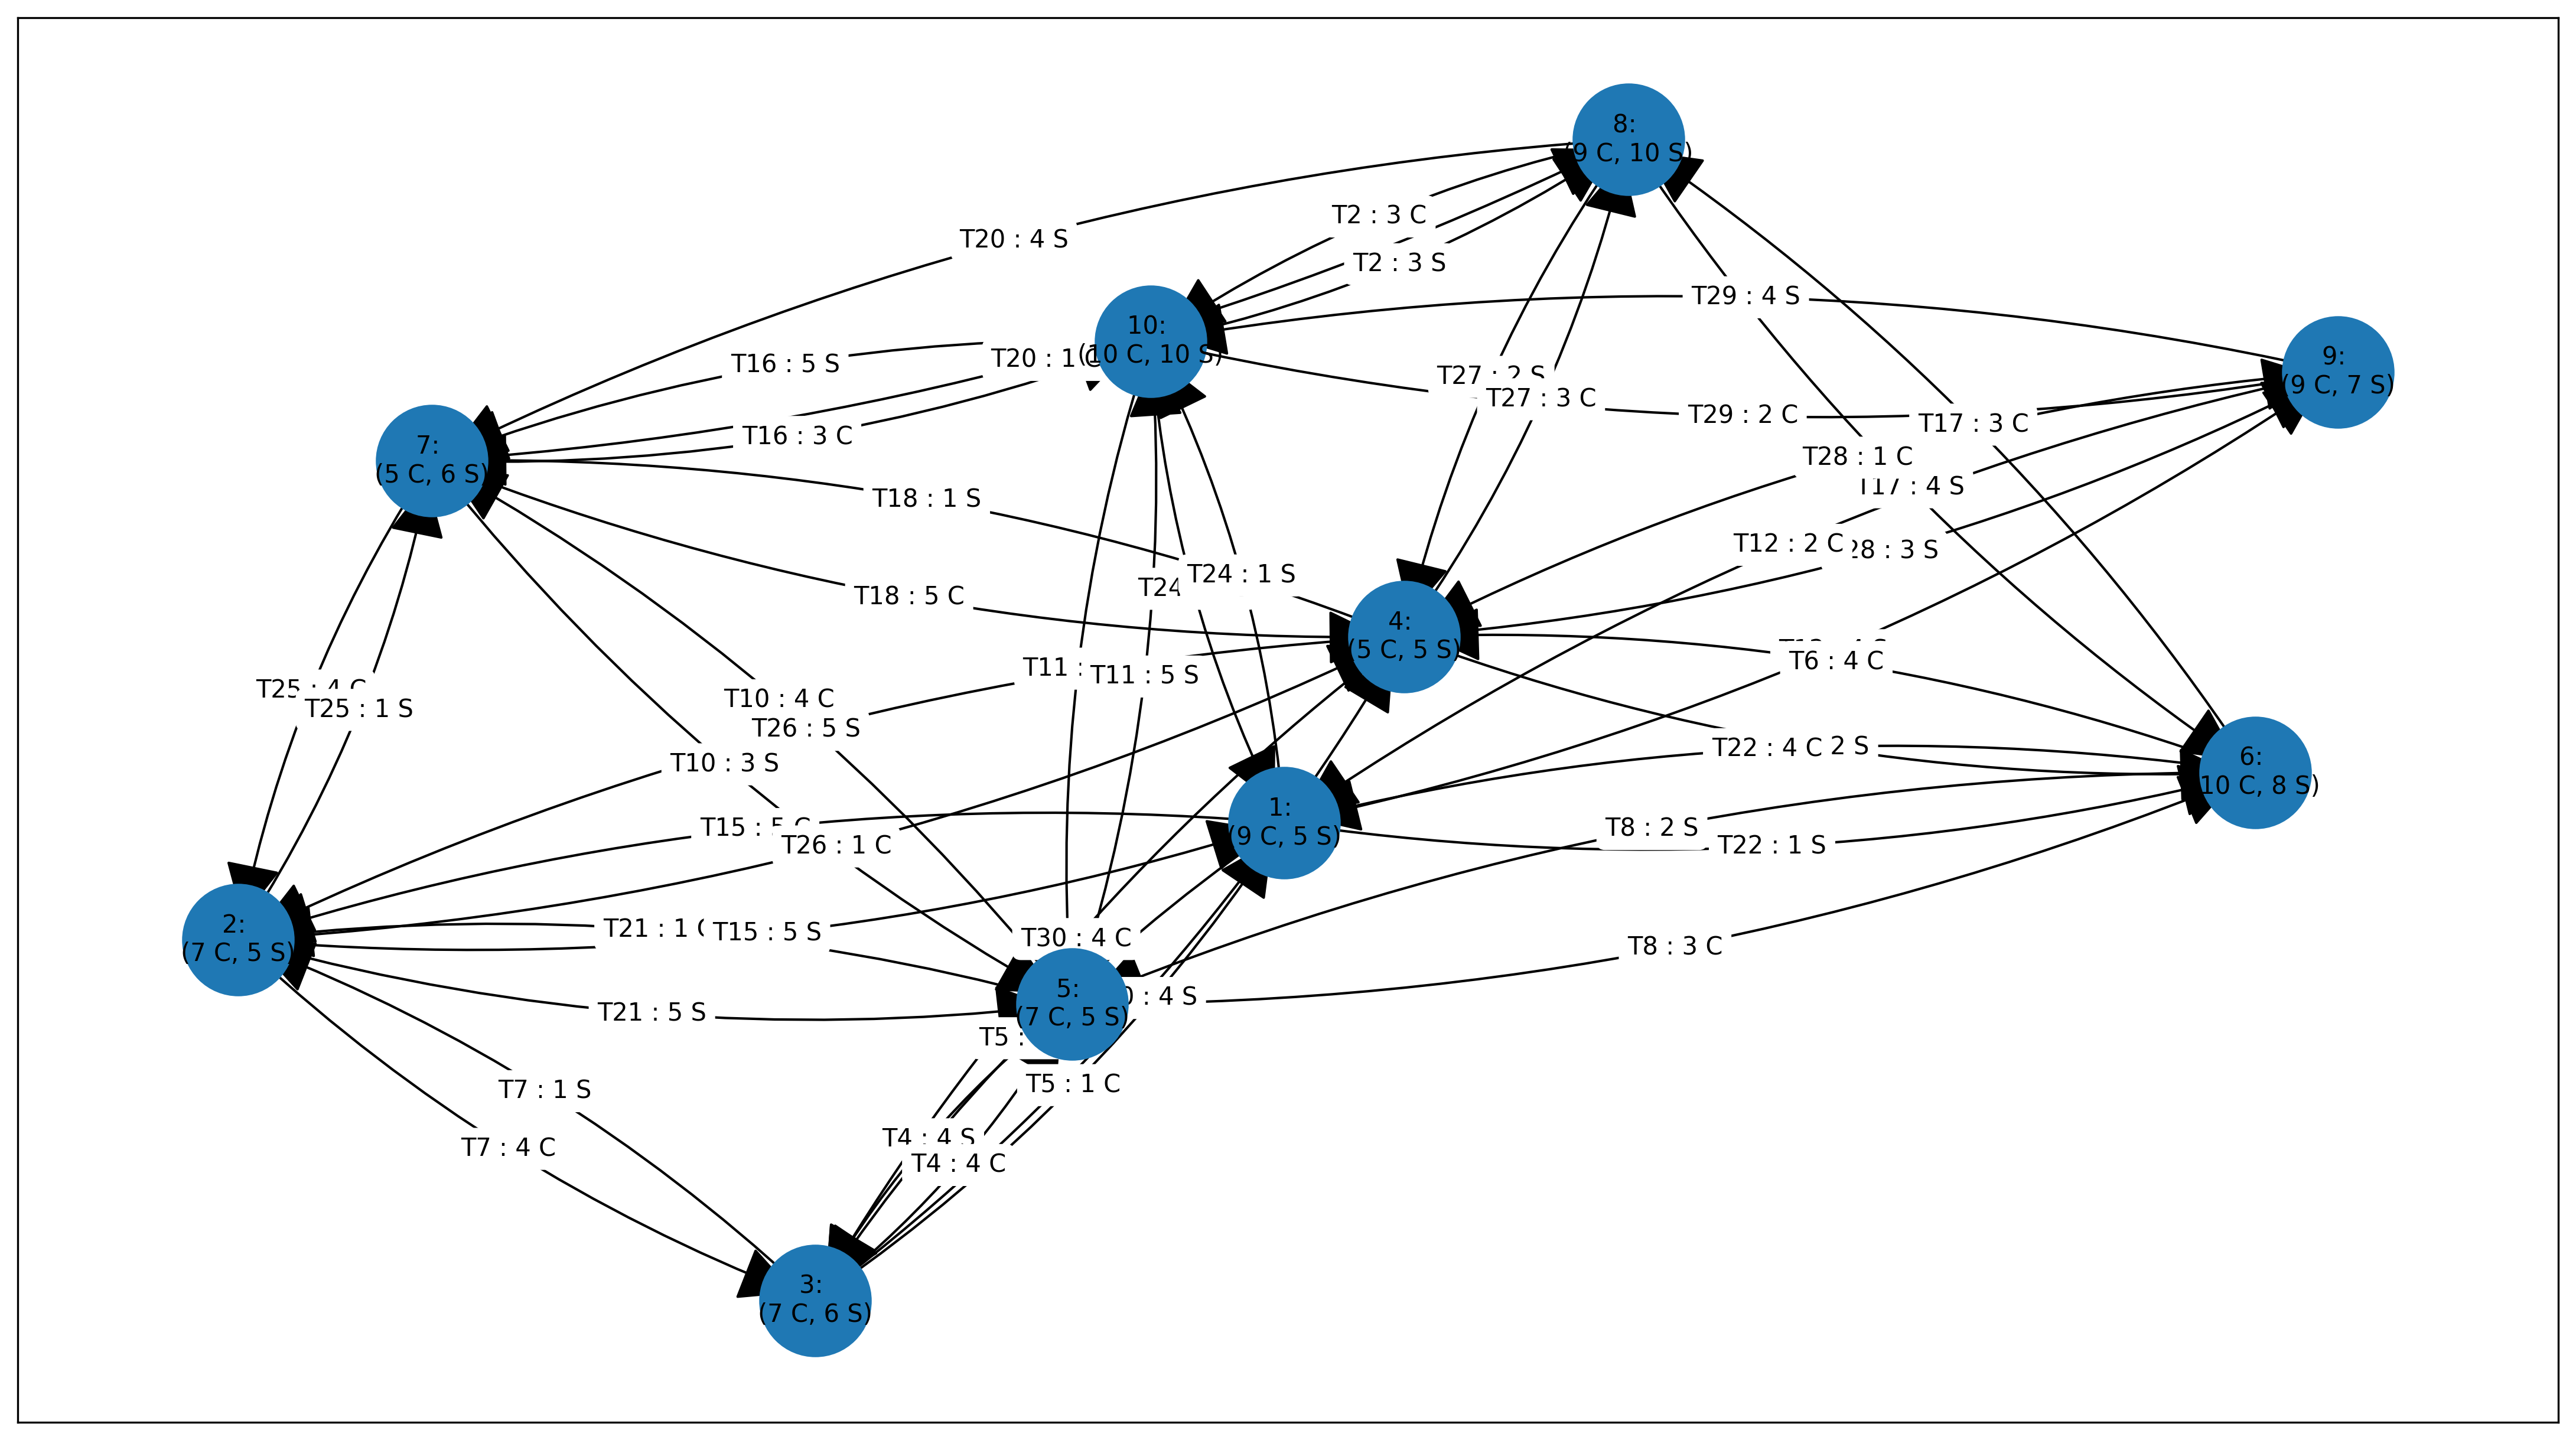

In [24]:
draw_transaction_graph(parties, transactions)

In [25]:
x, obj, lam = create_variables_and_objective_function(parties, transactions)

In [26]:
M = 1.5
obj = obj.subs({lam : M})
len(obj.variables)



74

In [27]:
from qubovert.sim import anneal_qubo
from scipy.stats import norm
from pprint import pprint
from copy import deepcopy
%time res = anneal_qubo(obj, num_anneals=10000)

for s in res:
    most_settled = 0
    resulting_parties = {}
    
    solution = s.state
    transactions_to_settle = []
    for sol in solution:
        if sol.split("_")[0] == 'x' and solution[sol] == 1:
            transactions_to_settle.append(sol.split("_")[1])
    settled_transactions = len(transactions_to_settle)
    current_parties = deepcopy(parties)
    for t in transactions_to_settle:
        transaction = int(t)
        from_party = transactions[transaction]['securities_from']
        to_party = transactions[transaction]['securities_to']
        currency_amount = transactions[transaction]['payment']['value']
        securities_amount = transactions[transaction]['delivery']['value']
        current_parties[from_party]['balance']['securities'] -= securities_amount
        current_parties[from_party]['balance']['currency'] += currency_amount
        current_parties[to_party]['balance']['securities'] += securities_amount
        current_parties[to_party]['balance']['currency'] -= currency_amount
    valid = True
    for p in current_parties:
        if current_parties[p]['balance']['currency'] < 0 or current_parties[p]['balance']['securities'] < 0:
            valid = False
    if valid and settled_transactions > most_settled:
        most_settled = settled_transactions
        resulting_parties = current_parties
print(f"Settled {most_settled} transactions.")
print("Final balances:")
resulting_parties
    

Wall time: 32.6 s
Settled 16 transactions.
Final balances:


{1: {'balance': {'currency': 10, 'securities': 5},
  'credit_limit': {'currency': 0, 'securities': 0}},
 2: {'balance': {'currency': 12, 'securities': 0},
  'credit_limit': {'currency': 0, 'securities': 0}},
 3: {'balance': {'currency': 15, 'securities': 4},
  'credit_limit': {'currency': 0, 'securities': 0}},
 4: {'balance': {'currency': 2, 'securities': 6},
  'credit_limit': {'currency': 0, 'securities': 0}},
 5: {'balance': {'currency': 11, 'securities': 0},
  'credit_limit': {'currency': 0, 'securities': 0}},
 6: {'balance': {'currency': 3, 'securities': 14},
  'credit_limit': {'currency': 0, 'securities': 0}},
 7: {'balance': {'currency': 1, 'securities': 8},
  'credit_limit': {'currency': 0, 'securities': 0}},
 8: {'balance': {'currency': 9, 'securities': 11},
  'credit_limit': {'currency': 0, 'securities': 0}},
 9: {'balance': {'currency': 8, 'securities': 5},
  'credit_limit': {'currency': 0, 'securities': 0}},
 10: {'balance': {'currency': 7, 'securities': 14},
  'credit_limit

In [28]:
transactions

{1: {'delivery': {'type': 's', 'value': 5},
  'payment': {'type': 'c', 'value': 2},
  'securities_from': 7,
  'securities_to': 8,
  'weight': 1},
 2: {'delivery': {'type': 's', 'value': 3},
  'payment': {'type': 'c', 'value': 3},
  'securities_from': 10,
  'securities_to': 8,
  'weight': 1},
 3: {'delivery': {'type': 's', 'value': 4},
  'payment': {'type': 'c', 'value': 3},
  'securities_from': 7,
  'securities_to': 8,
  'weight': 1},
 4: {'delivery': {'type': 's', 'value': 4},
  'payment': {'type': 'c', 'value': 4},
  'securities_from': 5,
  'securities_to': 3,
  'weight': 1},
 5: {'delivery': {'type': 's', 'value': 2},
  'payment': {'type': 'c', 'value': 1},
  'securities_from': 1,
  'securities_to': 3,
  'weight': 1},
 6: {'delivery': {'type': 's', 'value': 2},
  'payment': {'type': 'c', 'value': 4},
  'securities_from': 4,
  'securities_to': 6,
  'weight': 1},
 7: {'delivery': {'type': 's', 'value': 1},
  'payment': {'type': 'c', 'value': 4},
  'securities_from': 3,
  'securities_t

Reference: [Quantum Algorithms for Mixed Binary Optimization applied to Transaction Settlement](https://arxiv.org/abs/1910.05788)